In [1]:
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-question-pairs/train.csv.zip
/kaggle/input/quora-question-pairs/sample_submission.csv.zip
/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/test.csv.zip


This project aimed at developing a machine learning algorithm to identify whether pairs of questions on Quora were duplicates or not. The goal is to help Quora improve the quality of their platform by reducing the number of duplicate questions.

In [2]:
import seaborn as sns
from nltk.corpus import stopwords
import re
import unidecode
import matplotlib.pyplot as plt

# Importing Data

In [3]:
train=pd.read_csv('/kaggle/input/quora-question-pairs/train.csv.zip')
test=pd.read_csv('/kaggle/input/quora-question-pairs/test.csv.zip')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# EDA and Data Cleaning

In [5]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [6]:
train[['question1','question2']]=train[['question1','question2']].astype(str)
test[['question1','question2']]=test[['question1','question2']].astype(str)


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404290 non-null  object
 4   question2     404290 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:>

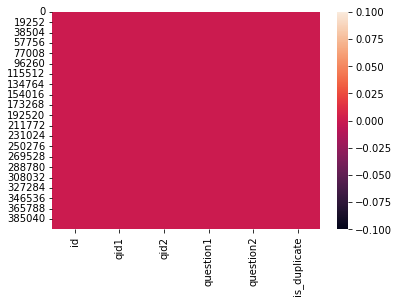

In [8]:
sns.heatmap(train.isnull())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

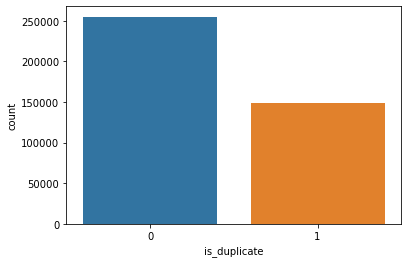

In [9]:
sns.countplot(train.is_duplicate)

In [10]:
def case_convert():
    train.question1 = [i.lower() for i in train.question1 ]
    train.question2= [i.lower() for i in train.question2 ]
    test.question1 = [i.lower() for i in test.question1 ]
    test.question2 = [i.lower() for i in test.question2 ]

def remove_specials():
        train.question1= [re.sub(r"[^a-zA-Z]"," ",text) for text in train.question1]
        train.question2= [re.sub(r"[^a-zA-Z]"," ",text) for text in train.question2]
        test.question1 = [re.sub(r"[^a-zA-Z]"," ",text) for text in test.question1]
        test.question2 = [re.sub(r"[^a-zA-Z]"," ",text) for text in test.question2]


def remove_shorthands():
    CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    texts = []
    for text in train.question1:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    train.question1 = texts
    texts.clear()
    for text in train.question2:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    train.question2 = texts
    texts.clear()
    for text in test.question1:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    test.question1 = texts
    texts.clear()
    for text in test.question2:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    test.question2 = texts
    
    

def remove_stopwords():
    texts = []
    stopwords_list = stopwords.words('english')
    for item in train.question1:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    train.question1 = texts
    texts.clear()
    for item in train.question2:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    train.question2 = texts
    texts.clear()
    for item in test.question1:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    test.question1 = texts
    texts.clear()
    
    for item in test.question2:
        string = ""
        for word in item.split(" "):
            if word.strip() in stopwords_list:
                continue
            else:
                string = string + " " + word
        texts.append(string)
    test.question2 = texts

def remove_accents():
   
    train.question1=[unidecode.unidecode(text) for text in train.question1 ] 
    train.question2= [unidecode.unidecode(text) for text in train.question2]
    test.question1 = [unidecode.unidecode(text) for text in test.question1]
    test.question2 = [unidecode.unidecode(text) for text in test.question2]

def normalize_spaces():
    
    train.question1=[re.sub(r"\s+"," ",text) for text in train.question1 ] 
    train.question2= [re.sub(r"\s+"," ",text) for text in train.question2]
    test.question1 = [re.sub(r"\s+"," ",text) for text in test.question1]
    test.question2 = [re.sub(r"\s+"," ",text) for text in test.question2]
    

case_convert()
remove_shorthands()
remove_accents()
remove_specials()
remove_stopwords()
normalize_spaces()


In [11]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,step step guide invest share market india,step step guide invest share market,0
1,1,3,4,story kohinoor koh noor diamond,would happen indian government stole kohinoor...,0
2,2,5,6,increase speed internet connection using vpn,internet speed increased hacking dns,0
3,3,7,8,mentally lonely solve,find remainder math math divided,0
4,4,9,10,one dissolve water quikly sugar salt methane ...,fish would survive salt water,0


# **Machine Learning Approach**

## Feature engineering and feature extraction

* q1_len=Length of question 1
* q1_len=Length of question 2
* q1_word=No.of words in question 1
* q2_word=No.of words in question 2
* common_words=No. of common words in question 1 and question 2
* word_share_q1=Number of common words/No. of words in question 1
* word_share_q2=Number of common words/No. of words in question 2

In [12]:
#word len
train['q1_len']=train['question1'].str.len()
train['q2_len']=train['question2'].str.len()

#word count
train['q1_word']=train['question1'].apply(lambda x: len(x.split(" ")))
train['q2_word']=train['question2'].apply(lambda x: len(x.split(" ")))


#common words

train['s1']=train['question1'].apply(lambda x: x.split(" "))
train['s2']=train['question1'].apply(lambda x: x.split(" "))
train['common_words']= [len(set(a) & set(b)) for a, b in zip(train.s1, train.s2)]
train.drop(['s1','s2'],axis=1,inplace=True)


#common words share

train['word_share_q1']=round(train['common_words']/train['q1_word'],2)
train['word_share_q2']=round(train['common_words']/train['q2_word'],2)



## Analyzing the new features

1. q1_len and q2_len

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


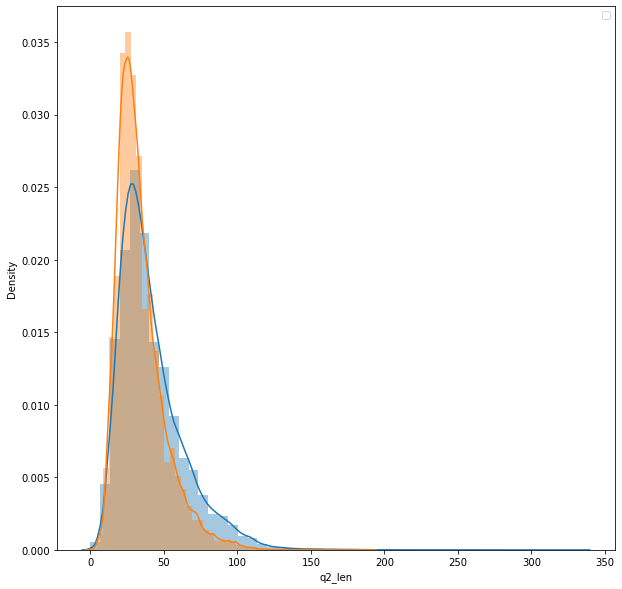

In [13]:
plt.figure(figsize=(10,10))
sns.distplot(train[train['is_duplicate']==0]['q1_len'])
sns.distplot(train[train['is_duplicate']==1]['q2_len'])
plt.legend()
plt.show()

2. q1_word and q2_word

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


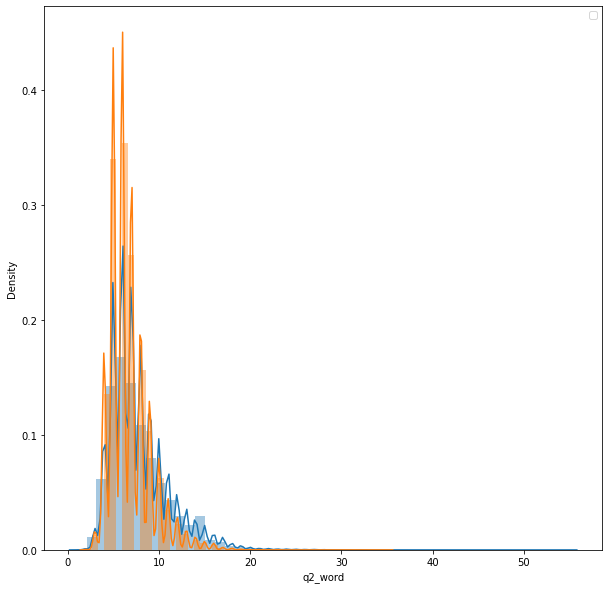

In [14]:
plt.figure(figsize=(10,10))
sns.distplot(train[train['is_duplicate']==0]['q1_word'])
sns.distplot(train[train['is_duplicate']==1]['q2_word'])
plt.legend()
plt.show()

3.  word_share_q1 and word_share_q2

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


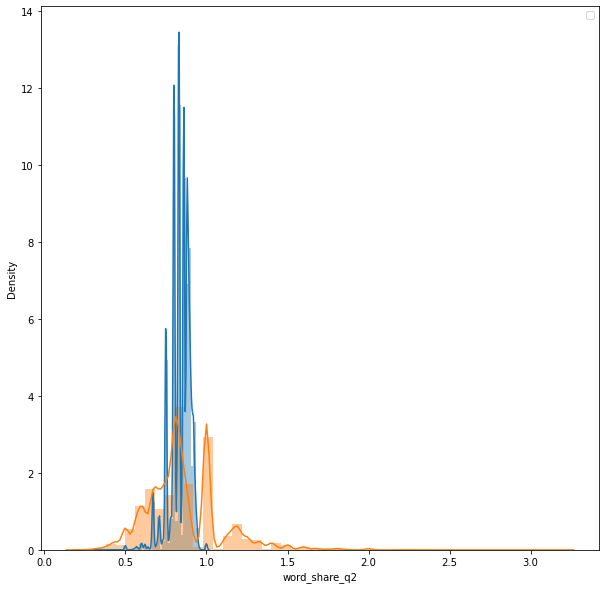

In [15]:
plt.figure(figsize=(10,10))
sns.distplot(train[train['is_duplicate']==0]['word_share_q1'])
sns.distplot(train[train['is_duplicate']==1]['word_share_q2'])
plt.legend()
plt.show()

## Spliting the data into test and train data

In [16]:
x=train.drop(['is_duplicate'],axis=1)
y=train['is_duplicate']

In [17]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=41
                                                    )
 

### Vectorizing question1 and question2 using tfidf vectorizer

In [18]:

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=3000)
traindf = vectorizer.fit_transform(x_train['question1']+' '+x_train['question2']).toarray()
testdf = vectorizer.fit_transform(x_test['question1']+' '+x_test['question2']).toarray()



In [19]:
x_train=x_train.drop(['question1','question2'],axis=1)



In [20]:
x_test=x_test.drop(['question1','question2'],axis=1)

In [21]:
x_test.head()

,id,qid1,qid2,q1_len,q2_len,q1_word,q2_word,common_words,word_share_q1,word_share_q2
155577,155577,243705,17614,39,18,7,5,6,0.86,1.20
9391,9391,18247,18248,82,85,14,15,13,0.93,0.87
233146,233146,207014,170677,22,26,5,5,4,0.80,0.80
259208,259208,229448,131741,55,110,9,17,7,0.78,0.41
60616,60616,105977,105978,38,35,7,7,6,0.86,0.86


In [22]:
x_train=np.concatenate([x_train.to_numpy(),traindf],axis=1)

In [23]:
x_test=np.concatenate([x_test.to_numpy(),testdf],axis=1)

## Modelling and prediction

### Random Forest classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test,y_pred)



0.726704443245188

In [25]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81    110820
           1       0.36      0.78      0.49     22596

    accuracy                           0.73    133416
   macro avg       0.65      0.75      0.65    133416
weighted avg       0.84      0.73      0.76    133416



### Logistic regression

In [26]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg.fit(x_train,y_train)
y_pred2 = lg.predict(x_test)
accuracy_score(y_pred2,y_test)


0.7214052287581699

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81    110820
           1       0.36      0.78      0.49     22596

    accuracy                           0.73    133416
   macro avg       0.65      0.75      0.65    133416
weighted avg       0.84      0.73      0.76    133416



# **Deep learning**

## Train test split

In [28]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train.drop('is_duplicate',axis=1),
                                                    train['is_duplicate'],
                                                    test_size=0.33,
                                                    random_state=41
                                                    )
 

In [29]:
print(x_train.shape,"'''''''",x_test.shape,"''''''''''''",y_test.shape,"''''''''",y_train.shape)

(270874, 12) ''''''' (133416, 12) '''''''''''' (133416,) '''''''' (270874,)


### Tokenizing the text

In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_vocab_size=2000
tokenizer=Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train['question1'])
train1=tokenizer.texts_to_sequences(x_train['question1'])
tokenizer.fit_on_texts(x_test['question1'])
test1=tokenizer.texts_to_sequences(x_test['question1'])

tokenizer2=Tokenizer(num_words=max_vocab_size)
tokenizer2.fit_on_texts(x_train['question2'])
train2=tokenizer2.texts_to_sequences(x_train['question2'])
tokenizer2.fit_on_texts(x_test['question2'])
test2=tokenizer2.texts_to_sequences(x_test['question2'])



Finding how many different tokens are present in the data


In [31]:
word2idx=tokenizer.word_index
V=len(word2idx)

### Padding sequence

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
train1_pad = pad_sequences(train1)
test1_pad=pad_sequences(test1)
train2_pad = pad_sequences(train2)
test2_pad=pad_sequences(test2)



In [33]:
dtrain=np.hstack((train1_pad,train2_pad))
dtest=np.hstack((test1_pad,test2_pad))
dtest=pad_sequences(dtest,maxlen=116)

In [34]:
dtest.shape

(133416, 116)

In [35]:
T=dtrain.shape[1]
word2idx=tokenizer.word_index
V=len(word2idx)
D=20


## Model training and validation

In [36]:
from keras.models import Model
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, Activation, BatchNormalization,Input,Embedding, GlobalMaxPooling1D

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(4)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(dtrain,y_train,
          epochs=5,
          validation_data=(dtest,y_test)
         
         )
model.summary()

2023-02-17 17:10:31.016156: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-02-17 17:10:31.417348: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
8465/8465 [==============================] - 183s 22ms/step - loss: 0.5588 - accuracy: 0.7153 - val_loss: 0.6654 - val_accuracy: 0.6316
Epoch 2/5
8465/8465 [==============================] - 182s 21ms/step - loss: 0.5229 - accuracy: 0.7408 - val_loss: 0.7029 - val_accuracy: 0.6343
Epoch 3/5
8465/8465 [==============================] - 180s 21ms/step - loss: 0.5028 - accuracy: 0.7550 - val_loss: 0.7010 - val_accuracy: 0.6325
Epoch 4/5
8465/8465 [==============================] - 176s 21ms/step - loss: 0.4871 - accuracy: 0.7648 - val_loss: 0.7323 - val_accuracy: 0.6278
Epoch 5/5
8465/8465 [==============================] - 174s 21ms/step - loss: 0.4738 - accuracy: 0.7736 - val_loss: 0.7697 - val_accuracy: 0.6226
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 116)]             0         
_________________________________________________________

I have attempted to solve the Quora Duplicate Question problem using both machine learning and deep learning approaches. Out of the two, I found that machine learning with feature engineering performed the best, achieving an accuracy of 85% using a random forest classifier. I am open to any suggestions on how I can improve this model and streamline my workflow. If you found my work helpful, I would appreciate an upvote.****